# Analyze mind-matching results

In [1]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from lib import cached_request, paged_cached_request
from get_semantic_scholar_info import find_best_author_match

"""
df_users = pd.read_csv('data/input/CNN19_MindMatchData_20190828_fixed.csv')
df_users = df_users.rename(columns={'RegistrantID': 'registrant_id',
                                    'RepresentativeWork': 'abstracts'}).sort_values('registrant_id').reset_index(drop=True)
df_users.head()

df_matches = pd.read_json('data/input/CNN19_MindMatch_Pairs_20190828.json')
df_users = df_users.merge(df_matches, left_on='registrant_id', right_on='registrant_id', how='right')

df_users = df_users.sort_values('registrant_id').reset_index(drop=True)
"""

min_year = 2020
min_date = '2020-05-01'
max_coauthors = 25

df_users = pd.read_json('data/transformed/nmc2.json', orient='table')

/Users/patrickmineault/miniconda3/envs/ccn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_users.head()

,full_name,institution,computational_score,registration_date,meeting_platform,abstracts,coi,firstname,google_scholar,participate_mind_match,email,lastname,participate_grouped_mind,academic_status,personal_page,collaboration_score,create_time,registrant_id,matches_info
0,Dylan Festa,Albert Einstein College of Medicine (grid.2519...,1,2020-05-19 16:06:07.367949+00:00,[],Response variability is ubiquitous in cortex a...,"[Guillaume Hennequin, Mate Lengyel, Ruben Coen...",Dylan,https://scholar.google.com/citations?user=RVO3...,True,dylan.festa@einsteinmed.org,Festa,True,Post-doc,,0.7,2020-05-19 21:05:36.027536+00:00,020z1HEqO0cyMNZr7iXJ5uLTr2U2,"[{'fullname': 'Jianjiao Chen', 'email': 'jic13..."
1,Ajay Talati,Imperial College London (grid.7445.2),0.5,2020-04-24 00:12:47.862990+00:00,[Skype],"Metacognition, mindfulness, creativity, social...",[],Ajay,,True,ajaytalati@googlemail.com,Talati,True,Other,,0.5,2020-04-15 21:31:02.385842+00:00,02V6iZkv7Ca6UT3LHVQxww2w9NH3,"[{'id': 'Pz0h2GOZf8aMJtFC0pvtJzf1BR12', 'email..."
2,Raman Saggu,Harvard Medical School (grid.471403.5),0.5,2020-04-21 13:21:04.402546+00:00,[],I work on the mouse connectome and non-human p...,[],Raman,,True,raman.saggu@wolfson.oxon.org,Saggu,True,Other,,0.5,2020-04-21 18:21:04.600495+00:00,02bGQxsy6Kdt36QZg0t0P96oraC2,"[{'email': 'psylzl@zzu.edu.cn', 'id': '9wHtoen..."
3,Nicolas PINTO PARDO,Viña del Mar University (grid.441845.8),0.5,2020-04-21 13:23:29.490836+00:00,"[Zooom.us, Go To Meeting, Hangouts, Skype, Mes...","Cyclin-dependent kinase 5 (Cdk5), a serine/thr...",[],Nicolas,https://scholar.google.com/citations?user=a4eM...,True,npinto@hcuch.cl,PINTO PARDO,True,Professor,https://www.linkedin.com/in/dr-nicol%C3%A1s-pi...,0.8,2020-04-21 18:23:29.675381+00:00,0A6IF9rLDsRyHVZ7IKelzM8je9A3,"[{'email': 'npinto@hcuch.cl', 'id': '0A6IF9rLD..."
4,Clarissa Whitmire,Max Delbrück Center for Molecular Medicine (gr...,0.5,2020-05-19 00:20:22.264666+00:00,[Zooom.us],I am interested in working at the intersection...,[],Clarissa,https://scholar.google.de/citations?user=Q-3EI...,True,clarissa.whitmire@mdc-berlin.de,Whitmire,True,Post-doc,,0.5,2020-05-19 05:20:22.669540+00:00,0Q4BKe5V8eccDNwFWk4mr8BVAly1,"[{'fullname': 'Marco Lin', 'id': 'aiv725sWV4bu..."


In [3]:
sorted(df_users.full_name)[:10]

['Aakash Agrawal',
 'Aaron Wong',
 'Abdorreza Goodarzi Nick',
 'Abhishek Dave',
 'Abigail Noyce',
 'Adam Steel',
 'Adam Willats',
 'Adil Khan',
 'Aditi Bishnoi',
 'Adrian Bondy']

In [4]:
best_scores = []
inferred_ids = []
user_matches = {}
all_scores = []

for _, user in tqdm(df_users.iterrows()):
    fullname = (user['full_name']).replace('-', ' ').replace('.', ' ').replace("'", " ").replace(' ', '+')

    url = f'https://api.semanticscholar.org/graph/v1/author/search?query={fullname}&fields=affiliations,papers.fieldsOfStudy,papers.title,papers.abstract,papers.authors'
    q = paged_cached_request(url)
    scores = np.array(find_best_author_match(q, user.to_dict()['abstracts']))

    if len(scores) == 0:
        best_scores.append(0)
        inferred_ids.append(None)
    else:
        all_scores += list((set(scores) - {scores.max()}))
        best_scores.append(scores.max())
        inferred_ids.append(q['data'][scores.argmax()]['authorId'])

    user_matches[user['registrant_id']] = {'best_score' : best_scores[-1],
                                           'inferred_id': inferred_ids[-1],
                                           'n_matches': len(scores)}

440it [01:10,  6.27it/s] 


Find a minimum threshold to find a match acceptable. Set it so that it's 3 standard deviations higher than the mean max of random people in this dataset. For people whose name only comes up one time, we can use a lower threshold, whereas for people with multiple matching profiles we have to be more stringent.

In [5]:
# Calculate the mean and standard deviation of a max score
all_scores = sorted(all_scores)
all_scores_trunc = np.array(all_scores[int(.02 * len(all_scores)):-int(.02 * len(all_scores))])
#plt.hist(all_scores_trunc)

nboot = 500
threshes = []

for i in range(100):
    idx = np.floor(all_scores_trunc.shape[0] * np.random.rand(nboot, i+1)).astype(int)
    maxes = np.max(all_scores_trunc[idx], axis=1)
    threshes.append(np.mean(maxes) + 3 * np.std(maxes))

Text(0, 0.5, '3 SD threshold')

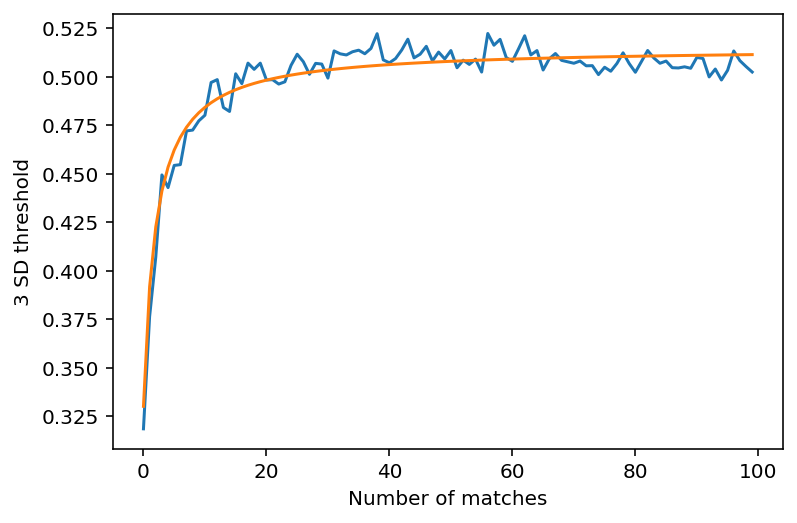

In [6]:
plt.plot(threshes)
x = np.arange(100)
plt.plot(.515 - (.515 - .33 ) * 2 / (2 + x))
plt.xlabel('Number of matches')
plt.ylabel('3 SD threshold')

In [7]:
import matplotlib.pyplot as plt

assert all(df_users['registrant_id'].values == np.array(list(user_matches.keys())))

df_users['ssid'] = [x['inferred_id'] for x in user_matches.values()]
df_users['ssid_score'] = [x['best_score'] for x in user_matches.values()]
df_users['ssid_matches'] = [x['n_matches'] for x in user_matches.values()]

# Use a sliding threshold, where the threshold for those with 1 match is .3 and those with
x = df_users.ssid_matches.values
threshold = .515 - (.515 - .33 ) * 2 / (2 + x)
df_users['ssid'] = np.where(df_users.ssid_score.values > threshold, df_users.ssid, np.nan)
df_users.ssid.isna().mean()

0.3522727272727273

In [63]:
df_users[df_users.ssid.isna() & (df_users.abstracts == '')]

,full_name,institution,computational_score,registration_date,meeting_platform,abstracts,coi,firstname,google_scholar,participate_mind_match,...,academic_status,personal_page,collaboration_score,create_time,registrant_id,matches_info,ssid,ssid_score,ssid_matches,new_collabs
7,Jesse Parent,Orthogonal Research and Education Lab,0.8,2020-05-20 11:11:34.848920+00:00,"[Zooom.us, Hangouts]",,[],Jesse,https://scholar.google.com/citations?hl=en&use...,True,...,Graduate students,https://www.jesparent.com,0.7,2020-05-20 14:55:57.234209+00:00,0hmdVEiYyRUVrsN7CY4NaWRkbXh2,"[{'email': 'j.yeon@gatech.edu', 'fullname': 'J...",NaN,0.191150,2,{}
12,Hamed Karimi,Royan Institute (grid.419336.a),0.8,2020-05-20 03:23:54.799955+00:00,"[Skype, Zooom.us]",,[],Hamed,https://scholar.google.com/citations?view_op=l...,True,...,Research assistant,https://hamed-karimi.github.io/,0.5,2020-05-20 08:21:13.133558+00:00,1M7t7J4PX5R0pX6mRERxeKSySbQ2,"[{'email': 'xxming4522@gmail.com', 'id': 'ApHo...",NaN,0.126890,19,{}
20,Ritesh Kumar,University of Hertfordshire (grid.5846.f),0.8,2020-05-20 09:46:04.491681+00:00,[Zooom.us],,[],Ritesh,https://scholar.google.com/citations?user=ls5b...,True,...,Post-doc,https://riteshkumarrai.wordpress.com/about/,0.5,2020-05-20 14:46:04.621078+00:00,2cHYDEkJFkdZIg1UD5ckNZ51trd2,"[{'fullname': 'Donghyung Lee', 'email': 'Dol12...",NaN,0.271353,100,{}
29,Melinda Zana,BioTalentum (Hungary) (grid.424211.0),0.2,2020-05-25 08:22:35.841924+00:00,[Go To Meeting],,[],Melinda,,True,...,Post-doc,https://www.linkedin.com/in/melindazana/,0.7,2020-05-04 14:16:47.549865+00:00,3zKGDTsCU6cxcQ601VD9bfNBj3i1,"[{'id': '0A6IF9rLDsRyHVZ7IKelzM8je9A3', 'email...",NaN,0.023817,1,{}
30,Pankaj Gupta,University of British Columbia (grid.17091.3e),0.4,2020-05-21 04:28:17.597141+00:00,[Hangouts],,[],Pankaj,https://scholar.google.com/citations?user=3Q5B...,True,...,Graduate student,,0.5,2020-05-21 09:28:17.777036+00:00,4GHZMJygIPOIGxKlSrUgACqBMHB3,"[{'email': 'pfeifferpaul90@gmail.com', 'fullna...",NaN,0.272687,100,{}
34,Sharbatanu Chatterjee,University College London (grid.83440.3b),0.6,2020-05-13 15:48:16.003758+00:00,[Zooom.us],,[],Sharbatanu,https://scholar.google.co.in/citations?user=u3...,False,...,Research assistant,http://sharbat.ch/,0,2020-05-13 20:46:49.667414+00:00,4rWAK3sPXbVTlmJmznP3rVIXOBo1,"[{'email': 'anne.voigt@charite.de', 'fullname'...",NaN,0.087263,2,{}
35,Wojciech Zajkowski,Cardiff University (grid.5600.3),0.3,2020-05-13 17:12:44.757595+00:00,[Zooom.us],,"[Jiaxiang Zhang, Robert Wilson, Brandon Turner...",Wojciech,https://scholar.google.com/citations?user=98tT...,True,...,Graduate student,,0.5,2020-05-13 22:09:18.712094+00:00,4t5fwTVnXSQJ9oIXVMJo52Sgvci1,"[{'fullname': 'Tsvi Achler', 'email': 'achler@...",NaN,0.083235,1,{}
38,Jeroen Smeets,Vrije Universiteit Amsterdam,0.3,2020-05-19 01:55:13.234247+00:00,[Zooom.us],,[],Jeroen,https://scholar.google.nl/citations?user=cypYO...,False,...,Professor,https://personal.fgb.vu.nl/~jsmeets/,0.3,2020-05-19 06:55:13.489725+00:00,53rnBRAOv8eWjWZqk6XWkWoKqXV2,"[{'fullname': 'Dinesh Natesan', 'id': 'l8bxkC8...",NaN,0.165643,7,{}
52,Nat Kinsky,Michigan Medicine (grid.412590.b),0.5,2020-05-13 12:42:52.025221+00:00,[Zooom.us],,"[Kamran Diba, Andrew Alexander, Jon Rueckemann...",Nat,https://scholar.google.com/citations?hl=en&use...,True,...,Post-doc,,0.5,2020-05-13 17:42:52.193865+00:00,6skpY3irGfbwUjskSc0BPFaVtw83,"[{'fullname': 'Aditi Bishnoi', 'id': 'JmSiurR8...",NaN,0.050644,1,{}
75,dun mao,New York University (grid.137628.9),0.2,2020-05-20 09:49:27.237201+00:00,[Zooom.us],,[],dun,https://scholar.google.com/citations?user=m7De...,True,...,Post-doc,,0.8,2020-05-20 14:49:27.396054+00:00,AoFgISKIndX7oGehHXeVEZJ7GMz2,"[{'email': 'YSHAERI@GMAIL.COM', 'id': 'NhNAUFf...",NaN,0.247425,33,{}


In [64]:
email = 'hello@xcorr.dev'

def find_open_alex(row):
    name = row.institution.split('(')[0].strip()
    grid_name = row.institution.split('(')[1].split(')')[0]
    query_params = '+'.join(name.split(' '))
    
    # Find the person
    q = requests.get(f"https://api.openalex.org/institutions?search={query_params}&mailto={email}")
    institution_id = None
    for result in q.json()['results']:
        if result['ids']['grid'] == grid_name:
            institution_id = result['id']
            break
            
    if institution_id is None:
        return None

    name = '+'.join(row.full_name.split(' '))
    q = requests.get(f"https://api.openalex.org/authors?search={name}&filter=last_known_institution.id:{institution_id}&mailto={email}")
    return q.json()

#https://api.openalex.org/works?mailto=hello@xcorr.dev
# Find the institution of each person
#q = requests.get(f"https://api.openalex.org/institutions?search=Princeton+University")
#q = requests.get(f"https://api.openalex.org/authors?filter=display_name.search:Qiong+Zhang")
#q.json()

#data = find_open_alex(df_users.loc[194])
#data

In [48]:
import requests
apiKey = '6a5600d1a0204c3a88c72563d0cb7166'
url = f'https://api.elsevier.com/content/search/author?query=Qiong+Zhang&apiKey={apiKey}'
q = requests.get(url)
q.json()

{'service-error': {'status': {'statusCode': 'AUTHORIZATION_ERROR',
   'statusText': 'The requestor is not authorized to access the requested view or fields of the resource'}}}

Not bad! We have found 65% of the people we wanted to. Now let's grab their co-authors list.

In [8]:
df_users.to_json('data/transformed/users.json', orient='table')

In [36]:
reidentify_group = []

new_collabs = []
for i, user in tqdm(df_users.iterrows()):
    if user.isna().ssid:
        new_collabs.append(set())
        continue

    q = cached_request(f'https://api.semanticscholar.org/graph/v1/author/{user.ssid}/papers?fields=authors,year,publicationDate')
    
    future_coauthors = []
    past_coauthors = [user.ssid]
    for paper in q['data']:
        if len(paper['authors']) >= max_coauthors:
            continue
    
        if paper['year'] is None:
            continue
        
        if (paper['year'] >= min_year + 1) or (paper['publicationDate'] is not None and paper['publicationDate'] >= min_date):
            # This means we could have influenced this.
            future_coauthors += [x['authorId'] for x in paper['authors']]
        else:
            # Pre-existing coauthorship
            past_coauthors += [x['authorId'] for x in paper['authors']]
            
        reidentify_group += paper['authors']
            
    new_collab = set(future_coauthors) - set(past_coauthors)
    new_collabs.append(new_collab)

440it [00:00, 1297.25it/s]


In [76]:
coauthors_map = {x['name'].lower(): x['authorId'] for x in reidentify_group}
df_ = df_users[df_users.ssid.isna()]
for i, row in df_.iterrows():
    if row['full_name'].strip().lower() in coauthors_map:
        print(row['full_name'])
        print(coauthors_map[row['full_name'].strip().lower()])
        print('Found')

Pankaj Gupta
46479974
Found
Wojciech Zajkowski
6666473
Found
Lei Wang
2152511710
Found


In [93]:
from scholarly import scholarly
from scholarly import ProxyGenerator

# Set up a ProxyGenerator object to use free proxies
# This needs to be done only once per session
pg = ProxyGenerator()
pg.FreeProxies()
scholarly.use_proxy(pg)

# Now search Google Scholar from behind a proxy
#search_query = scholarly.search_pubs('Perception of physical stability and center of mass of 3D objects')
#scholarly.pprint(next(search_query))
#scholarly.scholarly.use_proxy


In [126]:
import urllib

urllib.parse.parse_qs(
    urllib.parse.urlparse(df_[df_.google_scholar != ''].iloc[4].google_scholar).query
)['user']

['fiAvv4MAAAAJ']

In [120]:
urllib.parse.urlparse(df_[df_.google_scholar != ''].iloc[0].google_scholar).query

'hl=en&user=tSvD5eAAAAAJ'

In [98]:
author = scholarly.search_author_id('RVO3E
                                    REAAAAJ')
scholarly.fill(author, sections=['basics', 'publications', 'bib'])
author

{'container_type': 'Author',
 'filled': ['basics', 'publications'],
 'scholar_id': 'RVO3EREAAAAJ',
 'source': <AuthorSource.AUTHOR_PROFILE_PAGE: 'AUTHOR_PROFILE_PAGE'>,
 'name': 'Dylan Festa',
 'url_picture': 'https://scholar.googleusercontent.com/citations?view_op=view_photo&user=RVO3EREAAAAJ&citpid=1',
 'affiliation': 'Max Planck Institute for Brain Research',
 'organization': 8793041818083433026,
 'interests': ['computational neuroscience',
  'system neuroscience',
  'neural coding'],
 'email_domain': '@brain.mpg.de',
 'citedby': 23,
 'publications': [{'container_type': 'Publication',
   'source': <PublicationSource.AUTHOR_PUBLICATION_ENTRY: 'AUTHOR_PUBLICATION_ENTRY'>,
   'bib': {'title': 'Neuronal variability reflects probabilistic inference tuned to natural image statistics',
    'pub_year': '2021',
    'citation': 'Nature Communications 12 (1), 1-11, 2021'},
   'filled': False,
   'author_pub_id': 'RVO3EREAAAAJ:zYLM7Y9cAGgC',
   'num_citations': 15,
   'citedby_url': 'https://sc

In [95]:
results

{'container_type': 'Author',
 'filled': ['basics'],
 'scholar_id': 'RVO3EREAAAAJ',
 'source': <AuthorSource.AUTHOR_PROFILE_PAGE: 'AUTHOR_PROFILE_PAGE'>,
 'name': 'Dylan Festa',
 'url_picture': 'https://scholar.googleusercontent.com/citations?view_op=view_photo&user=RVO3EREAAAAJ&citpid=1',
 'affiliation': 'Max Planck Institute for Brain Research',
 'organization': 8793041818083433026,
 'interests': ['computational neuroscience',
  'system neuroscience',
  'neural coding'],
 'email_domain': '@brain.mpg.de',
 'citedby': 23}

In [89]:
df_users.google_scholar.iloc[0]

'https://scholar.google.com/citations?user=RVO3EREAAAAJ&hl=en'

In [75]:
df_users[df_users.full_name == 'Pankaj Gupta']

,full_name,institution,computational_score,registration_date,meeting_platform,abstracts,coi,firstname,google_scholar,participate_mind_match,...,academic_status,personal_page,collaboration_score,create_time,registrant_id,matches_info,ssid,ssid_score,ssid_matches,new_collabs
30,Pankaj Gupta,University of British Columbia (grid.17091.3e),0.4,2020-05-21 04:28:17.597141+00:00,[Hangouts],,[],Pankaj,https://scholar.google.com/citations?user=3Q5B...,True,...,Graduate student,,0.5,2020-05-21 09:28:17.777036+00:00,4GHZMJygIPOIGxKlSrUgACqBMHB3,"[{'email': 'pfeifferpaul90@gmail.com', 'fullna...",NaN,0.272687,100,{}


In [10]:
df_users['new_collabs'] = new_collabs

(array([378.,  44.,  12.,   1.,   3.,   0.,   0.,   1.,   0.,   1.]),
 array([  0. ,  16.6,  33.2,  49.8,  66.4,  83. ,  99.6, 116.2, 132.8,
        149.4, 166. ]),
 <BarContainer object of 10 artists>)

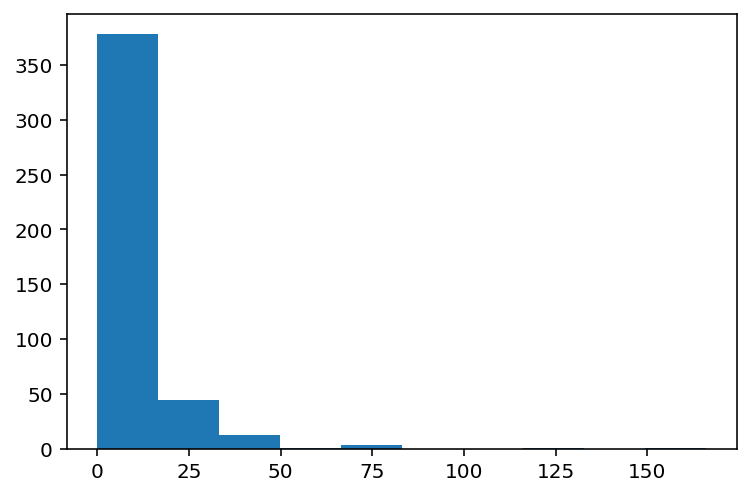

In [11]:
plt.hist(df_users.new_collabs.map(lambda x: len(x)))

In [12]:
(df_users.new_collabs.map(lambda x: len(x)) > 0).mean()

0.5318181818181819

53% of people had new collaborators since the Neuromatch conference.

In [13]:
session_ssids = set(df_users[~df_users.ssid.isna()].ssid.values)

In [16]:
# Calculate new collabs against a random background
#new_collabs

new_collabs_from_matches = []
new_collabs_from_sessions = []
for i, row in df_users.iterrows():
    user = df_users[df_users.registrant_id == row['registrant_id']]
    if user.empty:
        continue
        
    new_collabs = user.new_collabs.iloc[0]
    match_ssids = set(df_users[df_users.registrant_id.isin([x['registrant_id'] for x in row.matches_info])].ssid.values)
    
    assert len(match_ssids) > 0
    new_collabs_from_match = match_ssids.intersection(new_collabs)
    new_collabs_from_matches.append(len(new_collabs_from_match))
    
    new_collabs_from_session = session_ssids.intersection(new_collabs)
    new_collabs_from_sessions.append(len(new_collabs_from_session))
    
    if new_collabs_from_match:
        print(row)
        print(row['matches_info'])
        print(new_collabs_from_match)
        
print(sum(new_collabs_from_matches) // 2)
print(sum(new_collabs_from_sessions) // 2)

full_name                                                    Wilma Bainbridge
institution                             University of Chicago (grid.170205.1)
computational_score                                                       0.2
registration_date                            2020-05-15 12:00:45.635588+00:00
meeting_platform                                                   [Zooom.us]
abstracts                   During memory recall and visual imagery, reins...
coi                         [Nicole Rust, Chris Baker, Yalda Mohsenzadeh, ...
firstname                                                               Wilma
google_scholar              https://scholar.google.com/citations?user=cHZ2...
participate_mind_match                                                   True
email                                                      wilma@uchicago.edu
lastname                                                           Bainbridge
participate_grouped_mind                                        

In [24]:
df_users[df_users.full_name == 'Nicholas Hardy']

,full_name,institution,computational_score,registration_date,meeting_platform,abstracts,coi,firstname,google_scholar,participate_mind_match,...,academic_status,personal_page,collaboration_score,create_time,registrant_id,matches_info,ssid,ssid_score,ssid_matches,new_collabs
103,Nicholas Hardy,UCSF,0.6,2020-05-04 13:05:42.415697+00:00,"[Zooom.us, Hangouts]",Timing is fundamental to complex motor behavio...,"[Dean Buonomano, Karunesh Ganguly]",Nicholas,https://scholar.google.com/citations?user=tGAi...,True,...,Post-doc,,0.5,2020-05-04 18:05:42.689278+00:00,E439ZfWfUvWPM8vSfAmiMvhzheD3,"[{'fullname': 'Eunsol Park', 'email': 'eunsolp...",5095888,0.803742,10,"{34067426, 2036235, 2362670, 3162672, 14568306..."


In [28]:
df_users[df_users.full_name == 'Jean Laurens'].iloc[0].matches_info

[{'fullname': 'Nicolás Araneda Hinrichs',
  'email': 'nqo@pm.me',
  'id': 'Frde9GxmAjeECxnTPVPHgqkFk6s2',
  'full_name': 'Nicolás Araneda Hinrichs',
  'registrant_id': 'Frde9GxmAjeECxnTPVPHgqkFk6s2'},
 {'fullname': 'Yanisa Sunthornyotin',
  'id': 'MQsH39TZeYaZ2rbST6YOYETcLTm1',
  'email': 'mingignim@hotmail.com',
  'full_name': 'Yanisa Sunthornyotin',
  'registrant_id': 'MQsH39TZeYaZ2rbST6YOYETcLTm1'},
 {'email': 'wbast@cshl.edu',
  'id': '8aCujiLcbqScNrqkKzkbVAiCzNj2',
  'fullname': 'Walter Bast',
  'full_name': 'Walter Bast',
  'registrant_id': '8aCujiLcbqScNrqkKzkbVAiCzNj2'},
 {'fullname': 'Esaú Sirius Ventura Pupo',
  'id': 'OtWq7lGKeyYVhjWTlHRQXCTnENF3',
  'email': 'esau.sirius@gmail.com',
  'full_name': 'Esaú Sirius Ventura Pupo',
  'registrant_id': 'OtWq7lGKeyYVhjWTlHRQXCTnENF3'},
 {'email': 'jean.laurens@gmail.com',
  'id': '5TbR8mX0vqR1kZb7RQ4xBvaosMT2',
  'fullname': 'Jean Laurens',
  'full_name': 'Jean Laurens',
  'registrant_id': '5TbR8mX0vqR1kZb7RQ4xBvaosMT2'},
 {'email': 

In [30]:
df_users[df_users.full_name == 'dun mao'].abstracts

75    
Name: abstracts, dtype: object

In [23]:
df_users[df_users.full_name == 'Jian Liu']

,full_name,institution,computational_score,registration_date,meeting_platform,abstracts,coi,firstname,google_scholar,participate_mind_match,...,academic_status,personal_page,collaboration_score,create_time,registrant_id,matches_info,ssid,ssid_score,ssid_matches,new_collabs
74,Jian Liu,University of Leicester,0.8,2020-05-13 05:44:15.650599+00:00,"[Hangouts, Skype, Zooom.us]","Neural coding, including encoding and decodin...",[],Jian,https://scholar.google.com/citations?hl=en&use...,True,...,Professor,https://sites.google.com/site/jiankliu,0.5,2020-04-28 10:37:27.731006+00:00,AcRHpKfwxUgF1uPw722PCPC0SEq1,"[{'id': 'AcRHpKfwxUgF1uPw722PCPC0SEq1', 'fulln...",46700701,0.68093,100,"{49934986, 3351185, 5721279, 2153204837, 21141..."


In [ ]:
# Do a Q & D version of matching
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

encodings = model.encode(df_users.abstracts.fillna('').values.tolist())

In [ ]:
match_scores = encodings @ encodings.T

Verify that matches are better than chance.

In [ ]:
plt.imshow(match_scores)

In [ ]:
vals = []
vals_ctrl = []
for i, row in df_users.head(df_users.shape[0]).iterrows():
    # Look at the rows and the scores for those rows.
    if row.isna().abstracts:
        continue
    match_indexes = np.array(df_users[~df_users.abstracts.isna() & df_users.registrant_id.isin([x['registrant_id'] for x in row.matches_info])].index.values)
    
    vals += match_scores[i, match_indexes].tolist()
    vals_ctrl += match_scores[(i - 1), match_indexes].tolist()

In [ ]:
match_indexes

In [ ]:
plt.hist(vals, np.linspace(0, 1))

In [ ]:
plt.hist(vals_ctrl, np.linspace(0, 1))

In [ ]:
#vals_ctrl.mean()
print([np.mean(vals), np.std(vals)])
print([np.mean(vals_ctrl), np.std(vals_ctrl)])